(example-mzi)=
# Mach-Zehnder interferometer

In this tutorial, we'll define and simulate a simple circuit known as a
Mach-Zender Interferometer (MZI). It assumes you've read the previous tutorial, 
[intro](./intro).

Simphony uses [SAX](https://flaport.github.io/sax/index.html) to define 
models and simulate circuits, which uses 
[JAX](https://jax.readthedocs.io/en/latest/index.html) as a computational 
engine. JAX can provide a nice speedup for larger circuits if their models are 
appropriately defined and you have a GPU. Otherwise, it will run perfectly fine 
on a CPU.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax

## Deconstructing the MZI

In an MZI, light entering the circuit is split and travels down two paths of
differing lengths. When the light is recombined, it interferes, and the output
is frequency-dependent.

```{figure} /_static/images/mzi.png
:alt: waveguide
:align: center

A basic MZI. 
```

The MZI we'll create can be broken down into constituent parts. Simphony
includes models for these constituent parts below:

```{figure} /_static/images/mzi_outline_ports_marked.png
:alt: mzi
:align: center

Reusable components in an MZI.
```

The grating couplers are the input and output for light in the circuit. The
Y-branch can split and recombine light, and because the waveguides which carry
light across the circuit are different lengths, this produces interference when
the light is recombined at the second Y-branch. We can now begin defining our
circuit in Simphony using the components we have identified.


## Defining the circuit

First we need to import the necessary Simphony modules. The ``siepic`` model
library and the ``ClassicalSim`` simulator will be
all that we need. We will also import ``matplotlib.pyplot``, from outside of
Simphony, to view the results of our simulation.

In [2]:
from simphony.libraries import siepic

Simphony uses SAX as a backend s-parameter solver. A circuit contains a 
netlist, which is a collection of component instances, their connections, and 
exposed ports; and a list of models, which makes it easy to swap out different
models without rewriting your netlist, and seeing how the circuit behavior
changes.

The netlist is a dictionary with three fields:

* ``"instances"``: A dictionary of instance names to component model strings.
    You will define the string-to-model mapping later.
* ``"connections"``: A dictionary of ports to ports in the form 
    ``"instance_name,port_name": "instance_name,port_name"``.
* ``"ports"``: Since a SAX circuit is basically a model itself, and could be
    used in other circuits, it has exposed ports. This field is a dictionary 
    mapping port names of the composite object to the ports of its constituent
    instances.

In [3]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "left": "ybranch",
            "top": "waveguide",
            "bottom": "waveguide",
            "right": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "left,o0",
            "left,o1": "top,o0",
            "left,o2": "bottom,o0",
            "top,o1": "right,o1",
            "bottom,o1": "right,o2",
            "right,o0": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

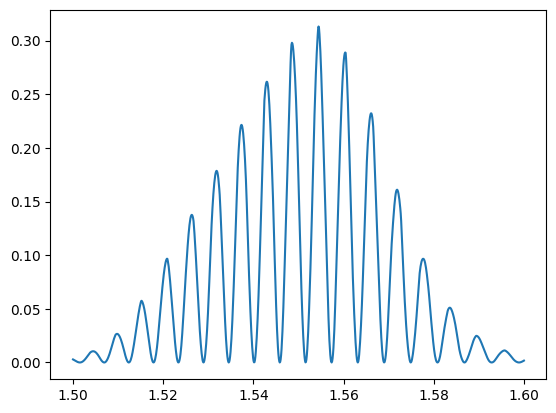

In [4]:
wl = jnp.linspace(1.5, 1.6, 1000)
S = mzi(wl=wl, top={"length": 150.0}, bottom={"length": 50.0})
plt.plot(wl, jnp.abs(S["out", "in"])**2)

```{note}
There are several different ways of connecting components
in Simphony, and many are demonstrated in this example,
with comments included.

You may also wish to rename pins for better semantics when
writing your own circuit. This can be done with
``component.rename_pins("new_pin1", "new_pin2", ...)``, on
any of the components we have created.

``rename_pins`` can be called on a model itself. This will
create default names for any new component you instantiate
of that model.
```

To help with debugging, there's a convenient little function that shows all components, their ports, and their connection status. Just like on switches, ``|`` means connected, and ``O`` means open or available.

In [14]:
print(ckt.port_info())

"circuit1" contains 6 models:
<GratingCoupler at 0x7f1bc41d4c90 (o: [+o0, o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1bc4131a10>
  O <OPort "o1" at 0x7f1bc4130150>
<YBranch at 0x7f1bc41bad90 (o: [+o0, +o1, +o2], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1ba40fe750>
  | <OPort "o1" (connected) at 0x7f1ba40fd550>
  | <OPort "o2" (connected) at 0x7f1ba40fded0>
<Waveguide at 0x7f1be47603d0 (o: [+o0, +o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1bc418f590>
  | <OPort "o1" (connected) at 0x7f1bc418ce50>
<Waveguide at 0x7f1ba41a0b90 (o: [+o0, +o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1be47b1650>
  | <OPort "o1" (connected) at 0x7f1be4756050>
<GratingCoupler at 0x7f1ba4133c90 (o: [+o0, o1], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1ba41343d0>
  O <OPort "o1" at 0x7f1bc41bc8d0>
<YBranch at 0x7f1bc4143410 (o: [+o0, +o1, +o2], e: [None])>:
  | <OPort "o0" (connected) at 0x7f1ba41329d0>
  | <OPort "o1" (connected) at 0x7f1ba41307d0>
  | <OPort "o2" (conn

We can even visualize the connections using NetworkX:

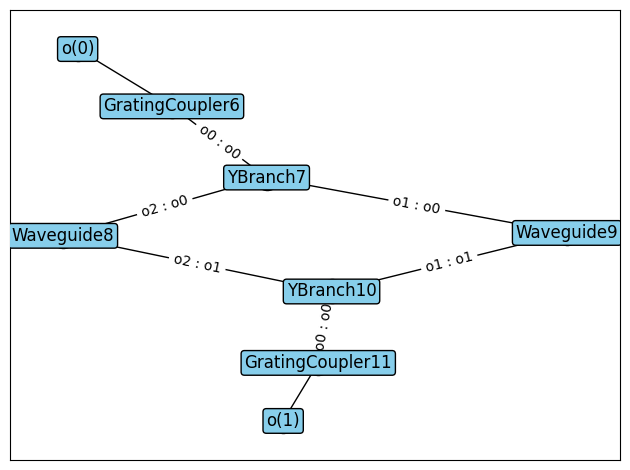

In [15]:
ckt.plot_networkx()
plt.show()

These are all the connections required to define our circuit. The next step will be to run the simulations.

## Sweep simulation

First, we'll do a standard sweep simulation. We define the simulator, the wavelength range to run, and then add an ideal laser to 
the input and ideal photodetectors to the output of our circuit. Note that simphony uses microns as the standard wavelength unit.

In [16]:
from simphony.simulation import ClassicalSim
# import jax.numpy as jnp

wl = np.linspace(1.5, 1.6, 1000)

sim = ClassicalSim(ckt=ckt, wl=wl)
laser = sim.add_laser(ports=ckt.o(0), power=1.0)
detector = sim.add_detector(ports=ckt.o(1))

Now we simulate.

In [17]:
result = sim.run()

The list of detectors in the simulation result have some handy functions for plotting the data. Or, you can access the data directly from its ``.wl`` and ``.power`` attributes.

<Axes: xlabel='Wavelength (um)', ylabel='Power (mW)'>

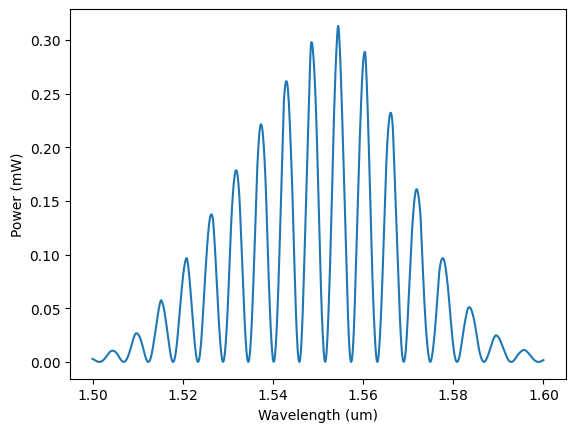

In [18]:
result.detectors[0].plot()

You can also access the underlying data directly. Here we use [``matplotlib``](https://matplotlib.org/) to plot the magnitude squared of scattering parameters of the MZI.

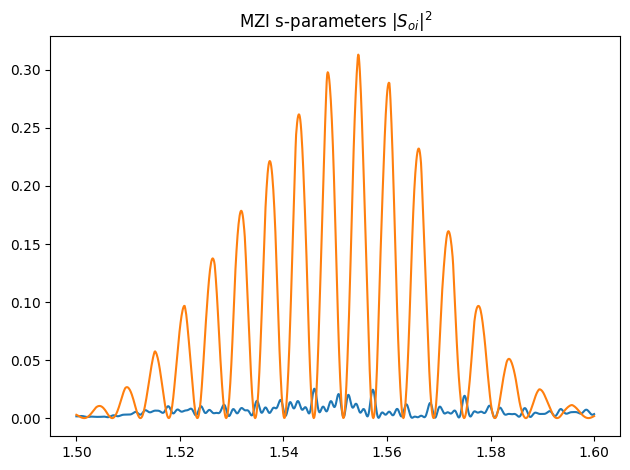

In [19]:
wl = result.wl
s = result.s_params

plt.plot(wl, np.abs(s[:,0])**2)
plt.title(r"MZI s-parameters $|S_{oi}|^2$")
plt.tight_layout()
plt.show()